# Lab 2: Bifurcations

## Problem 1 (4 points total)

You have been given signals of human brain activity obtained using an EEG.

The signal is received in two states - first, the subject solves a mathematical problem in his mind, then, having solved the problem, he stops thinking about anything :).

Your task is to find the bifurcation point in the brain activity of the subject - that is, the point at which the signal qualitatively changes its behavior.

In this case, it will be the point in time at which the person stopped solving the problem.

During this problem, you will be able to practice using Newton's method and searching for bifurcations on a one-dimensional problem, which will be very useful in the second task, which will be more difficult.

### Libraries

You are not allowed to use any other Python libraries except the ones listed below :(

In [2]:
%load_ext jupyter_black

In [3]:
import os.path as osp
from matplotlib import pyplot as plt
import numpy as np
from numba import njit
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d

import mne
from tqdm.auto import trange, tqdm
from warnings import filterwarnings

filterwarnings("ignore")

### Read data

In [4]:
path = osp.join("Brain_EEG.npy")
power = np.load(path, allow_pickle=True)
sample_freq = 500.0
print(f"Signal sampling frequency={sample_freq} Hz")
power.shape

Signal sampling frequency=500.0 Hz


(700, 79694)

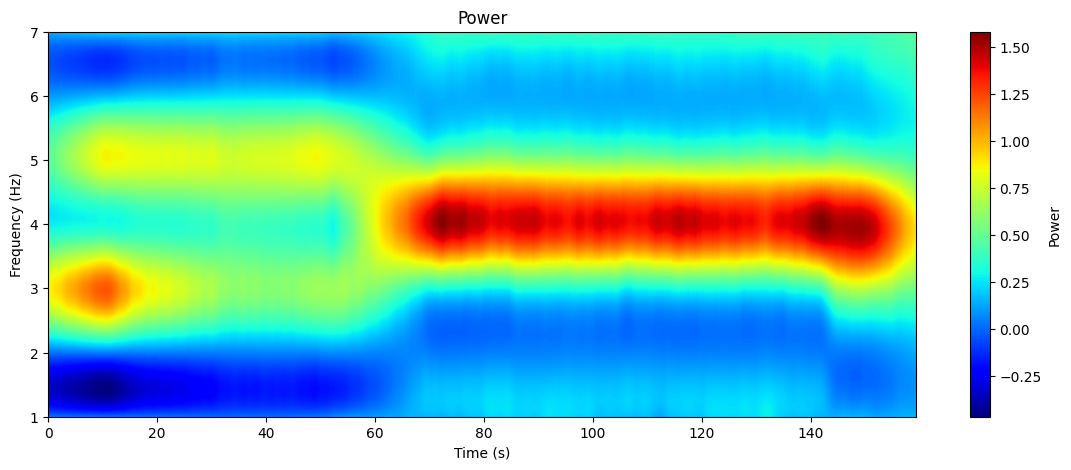

In [ ]:
# Signal

### Problem 1.1 Let's look at the signal (1 point)

1. Implement a method for calculating the mean and variance of the signal frequency

2. Plot the signal power in the frequency domain, calculate the average and the variance of its frequency. To make the signal smoother, we will consider a window in the time domain, and average the signal power over time in this window. The choice of window width is yours.

In [5]:
@njit  # you can remove, but it will work slower
def spectral_mean_std(
    omega_grid: np.ndarray,  # (n_frequencies,)
    power_1d: np.ndarray,  # (n_frequencies,)
):
    total_power = power_1d.sum()
    n_nonzero_power = (power_1d != 0).sum()

    mean = np.average(omega_grid, weights=power_1d)
    std = np.sqrt(
        (power_1d * ((omega_grid - mean) ** 2)).sum()
        * n_nonzero_power
        / (n_nonzero_power - 1)
        / total_power
    )
    return mean, std

In [8]:
def power_window(
    power: np.ndarray,
    window_size: int,
    window_begin: int = None,
):
    window_begin = 0 if window_begin is None else window_begin
    return power[:, window_begin : window_begin + window_size].mean(axis=1)


def plot_averaged_signal(
    power: np.ndarray,  # (n_frequencies, n_samples)
    window_size: int,
    window_begin: int = None,
):
    window_begin = 0 if window_begin is None else window_begin

    freq_range = np.linspace(0, 7, 700)
    power_averaged = power_window(power, window_size, window_begin=window_begin)

    mean, std = spectral_mean_std(freq_range, power_averaged)
    print(f"Mean frequency: {mean:0.2f} Hz")
    print(f"Spectral width: {std:0.2f} Hz")

    # plotting the power
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot()
    ax.plot(freq_range, power_averaged)
    ax.set_title(
        f"Average signal power from {window_begin/sample_freq*1000.0:0.0f}ms to {(window_begin+window_size)/sample_freq*1000.0:0.0f}ms"
    )
    ax.set_xlabel("Frequency, Hz")
    ax.set_ylabel("Power")
    ax.grid()
    plt.show()

Mean frequency: 3.59 Hz
Spectral width: 0.85 Hz


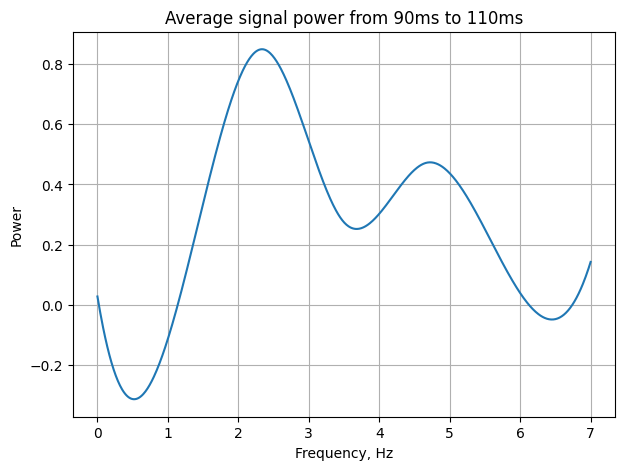

In [28]:
window_size = 10
plot_averaged_signal(power, window_size, window_begin=45)

### Problem 1.2  Search for signal parameters using the Newton method (1 point)

As you can see from your graph above (you can move the window to see how the signal behaves), the brain activity signal in the frequency domain resembles a combination of one or two Gaussians. Therefore, we will model it exclusively in this way.

In particular, your task is to take two Gaussians with averages $\omega_1, \omega_2$, and find these two parameters that minimize the deviation of the simulated signal from the real one using the Newton method. The variance for each Gaussian can be taken, for example, equal to the variance of the entire signal.

Your tasks:

1. Consider functional - square of the norm ($L_2 - norm$) of the deviation of model signal from the real one.
$$
    ||f(x)||_2^2 = \int_a^b f^2(x) \: dx, \quad x \in [a,b]
$$
$\quad$ In our problem, this functional is essentially just a function of two variables $\omega_1, \omega_2$, and for them it is an integral with two parameters. Accordingly, write down (in words or $\LaTeX$ formula) the necessary first-order local minimum conditions for it (relative to $\omega_1, \omega_2$).

2. These two conditions will be the boundary conditions for our task. Now, using Newton's method, find the frequencies that minimize the functional for our signal model

P.S. In order not to look for a constant by which the signal power is shifted relative to zero, you can simply subtract the average of its values at the edges from the signal.

#### You need to implement the Newton's method and all the necessary functions yourself! To do this, from the libraries you can use only `numpy`, `numba`.

First, to make sure that your implementation is correct, find the correct frequencies for the signal for which you know them.

In [11]:
def golden_section(f, low: float, high: float, tol: float = 1e-6, maxiter: int = 100):
    """
    Golden section optimizer made strictly for 1D optimization.
    """

    t_inv = 1 / ((1 + np.sqrt(5)) * 0.5)  # inverse golden ratio
    x_1 = low + (1 - t_inv) * (high - low)
    x_2 = low + t_inv * (high - low)
    l = high - low
    n_iter = 2
    f_1 = f(x_1)  # inital function values
    f_2 = f(x_2)

    while True:
        if f_1 > f_2:
            low = x_1
            x_1 = x_2
            x_2 = low + high - x_1
            f_1 = f_2
            f_2 = f(x_2)
        else:
            high = x_2
            x_2 = x_1
            x_1 = low + high - x_2
            f_2 = f_1
            f_1 = f(x_1)

        n_iter += 1

        l = high - low

        # breakpoint criteria
        if l < tol:
            termination = "achieved the step length lower than tolerance"
            break

        if n_iter == maxiter:
            termination = "achieved the maximal number of iterations"
            break

    return {"x": (low + high) * 0.5, "termination": termination}

In [12]:
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2.0 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma) ** 2)


@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(
        omega, omega2, sigma
    )


@njit
def residuals(omega1, omega2, omega_grid, y_true, sigma):
    """
    Calculate the residuals
    """
    return y_true - model_signal(omega_grid, omega1, omega2, sigma)


@njit
def functional(residuals):
    """
    Calculate the target functional
    """
    return np.linalg.norm(residuals)


@njit
def approximate_jacobian(func, omega1, omega2, dx, *args):
    """
    Calculate an approximation of Jacobian
    """
    dfdx = (func(omega1 + dx, omega2, *args) - func(omega1, omega2, *args)) / dx
    dfdy = (func(omega1, omega2 + dx, *args) - func(omega1, omega2, *args)) / dx
    return np.hstack((dfdx.reshape(-1, 1), dfdy.reshape(-1, 1)))


def gauss_newton_solver(
    omega_grid,
    y_true,
    omega1_init,
    omega2_init,
    sigma,
    dx=1e-3,
    tol=1e-6,
    max_iter=1_000,
    verbose=True,
):
    """
    An implementation of Gauss-Newton method that searches for optimal frequencies `omega1`, `omega2`
    """
    prev_omegas = np.array([omega1_init, omega2_init])
    curr_iter = 0

    while True:

        jacobian = approximate_jacobian(
            residuals, *prev_omegas, dx, omega_grid, y_true, sigma
        )
        prev_residuals = residuals(*prev_omegas, omega_grid, y_true, sigma).reshape(
            -1, 1
        )
        step = -(
            np.linalg.inv(jacobian.T @ jacobian + 1e-6 * np.eye(2))
            @ jacobian.T
            @ prev_residuals
        ).flatten()

        curr_omegas = prev_omegas + step
        prev_omegas = curr_omegas

        # learning_rate = golden_section(
        #     lambda l: functional(
        #         residuals(*(prev_omegas + l * step), omega_grid, y_true, sigma)
        #     ),
        #     0.0,
        #     1.0,
        # )["x"]

        # curr_omegas = prev_omegas + learning_rate * step
        # prev_omegas = curr_omegas

        # if verbose:
        #     print(f"Current omegas: {curr_omegas}")
        #     print(f"Current step: {step}")
        #     print(
        #         f"Current functional value: {functional(residuals(*curr_omegas, omega_grid, y_true, sigma)): 0.4f}"
        #     )
        #     print("\n" + "=" * 80 + "\n\n")

        curr_iter += 1
        if curr_iter == max_iter:
            if verbose:
                print("Maximum amount of iterations reached. Terminating...")
            break

        if functional(residuals(*curr_omegas, omega_grid, y_true, sigma)) < tol:
            if verbose:
                print("Functional value is less than tolerance. Terminating...")
            break

        if np.linalg.norm(step) < tol:
            if verbose:
                print("Step size is less than tolerance. Terminating...")
            break

    return curr_omegas

#### Now for real signal

Generated means: [2.5209508  4.60067282]

Functional value is less than tolerance. Terminating...
Resulting means: 2.00, 5.00


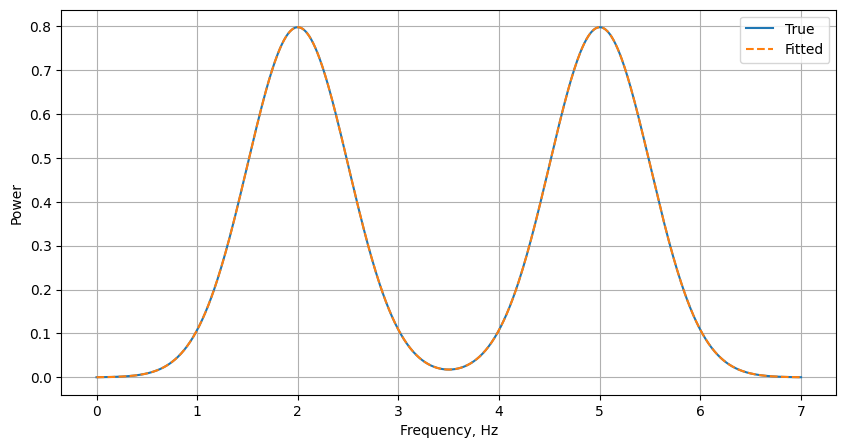

In [20]:
sigma_gen = 0.5
freq_range_test = np.linspace(0, 7, 700)
y_true = model_signal(freq_range_test, 2, 5, sigma_gen)

# _, sigma_test = spectral_mean_std(omega_grid, y_true)
# print(f"Assumed variance: {sigma_test:0.4f}")
sigma_test = 0.5

omegas_test = np.random.uniform(low=0.0, high=7.0, size=(2,))
print(f"Generated means: {omegas_test}\n")

omegas_result = gauss_newton_solver(
    freq_range_test, y_true, *omegas_test, sigma_test, verbose=True
)
print(f"Resulting means: {omegas_result[0]:0.2f}, {omegas_result[1]:0.2f}")


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.plot(freq_range_test, y_true, label="True")
ax.plot(
    freq_range_test,
    model_signal(freq_range_test, *omegas_result, sigma_test),
    "--",
    label="Fitted",
)
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel("Power")
ax.legend()
ax.grid()

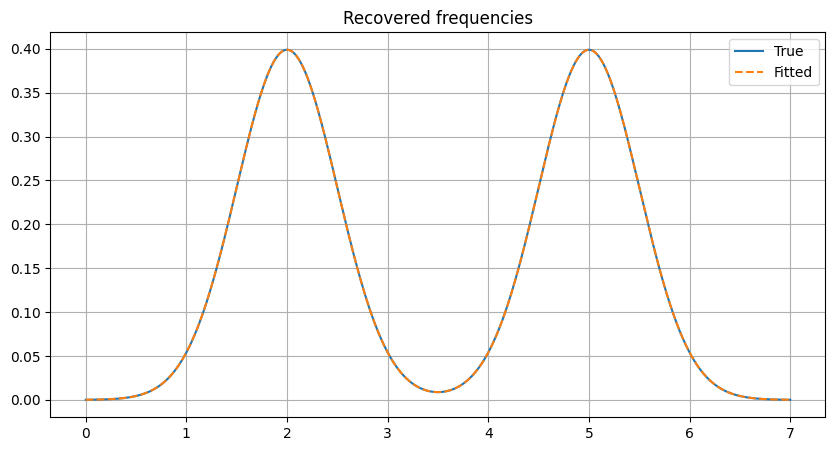

In [ ]:
# Example

Assumed variance: 0.6036
Generated means: [4.92059484 5.85379509]

Step size is less than tolerance. Terminating...
Resulting means: 2.38, 4.67
Determinant: 3980.227073704262


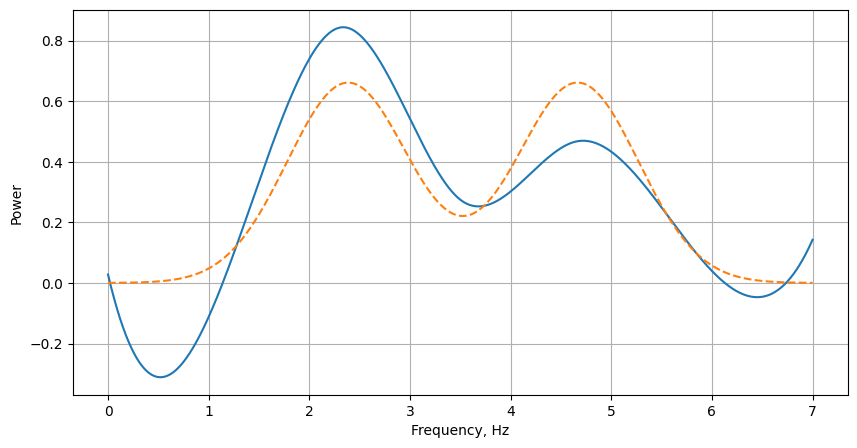

In [25]:
omega_grid = np.linspace(0, 7, 700)
y_true = power_window(power, 5, window_begin=0)

_, sigma_test = spectral_mean_std(omega_grid, y_true) / np.sqrt(
    2
)  # root of 2 since this is a sum of independant gaussians => gaussian
print(f"Assumed variance: {sigma_test:0.4f}")

omegas_test = np.random.uniform(low=0.0, high=7.0, size=(2,))
print(f"Generated means: {omegas_test}\n")
# omegas_test = np.array([4.0, 5.6])

omegas_result = gauss_newton_solver(
    freq_range_test, y_true, *omegas_test, sigma_test, verbose=True
)
print(f"Resulting means: {omegas_result[0]:0.2f}, {omegas_result[1]:0.2f}")

jacobian = approximate_jacobian(
    residuals, *omegas_result, 1e-3, omega_grid, y_true, sigma_test
)
hessian = jacobian.T @ jacobian

print(f"Determinant: {hessian[0, 0] * hessian[1, 1] - hessian[1, 0] * hessian[0, 1]}")

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.plot(freq_range_test, y_true, label="True")
ax.plot(
    freq_range_test,
    model_signal(freq_range_test, *omegas_result, sigma_test),
    "--",
    label="Fitted",
)
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel("Power")
ax.grid()
plt.show()

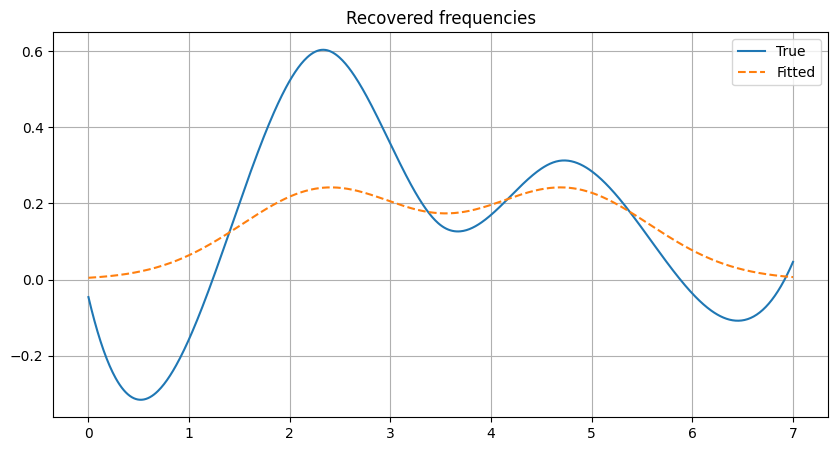

In [ ]:
# Example

### Problem 1.3 (1 point)

In Newton's method, you considered the Jacobian approximation. Now, moving the window along the signal, plot the absolute values of determinants of the found Jacobians. Again, use only `numpy`, `numba`

In [29]:
omega_grid = np.linspace(0, 7, 700)
power_split = np.split(
    power, np.arange(0, power.shape[1] // window_size) * window_size, axis=1
)
omegas_test = np.array([2.0, 5.0])

determinants = np.zeros(len(power_split))

for window_id, window in tqdm(enumerate(power_split), total=len(power_split)):
    # for window_id, window in enumerate(power_split[:75]):
    y_true = window.mean(axis=1)

    _, sigma_test = spectral_mean_std(omega_grid, y_true) / np.sqrt(
        2
    )  # root of 2 since this is a sum of independant gaussians => gaussian

    omegas_result = gauss_newton_solver(
        freq_range_test, y_true, *omegas_test, sigma_test, verbose=False
    )
    jacobian = approximate_jacobian(
        residuals, *omegas_result, 1e-3, omega_grid, y_true, sigma_test
    )
    hessian = jacobian.T @ jacobian

    determinants[window_id] = (
        hessian[0, 0] * hessian[1, 1] - hessian[1, 0] * hessian[0, 1]
    )

  0%|          | 0/7970 [00:00<?, ?it/s]

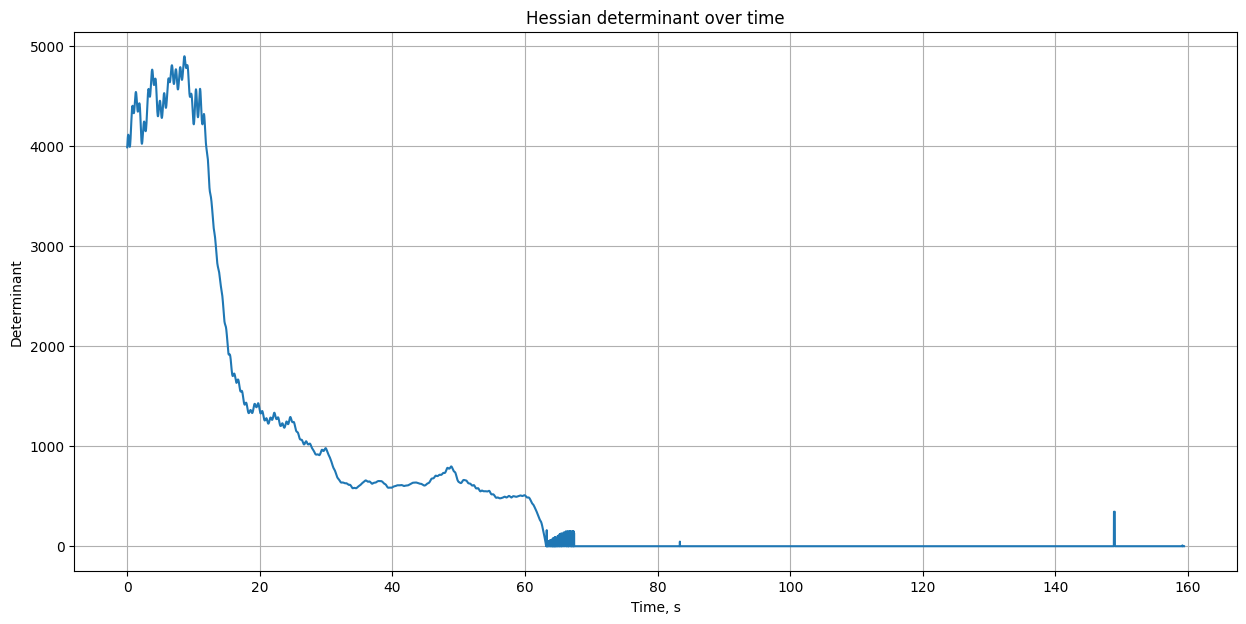

In [30]:
time = (
    np.append(np.arange(0, power.shape[1] // window_size) * window_size, power.shape[1])
    / sample_freq
)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()
ax.plot(time, determinants)
ax.set_xlabel("Time, s")
ax.set_ylabel("Determinant")
ax.set_title("Hessian determinant over time")
ax.grid()
plt.show()

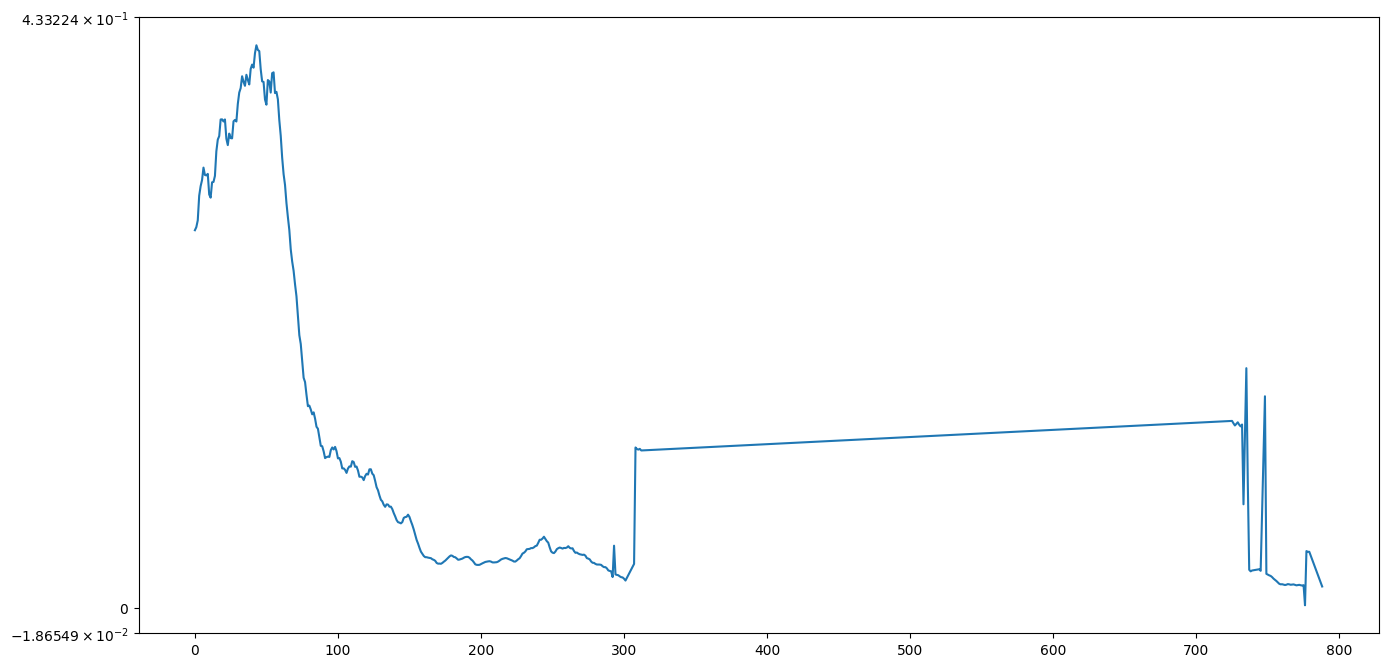

In [ ]:
# Example

#### As you can see, the determinant reaches zero for the first time at some point.

(not exactly zero, but since we are approximating the Jacobian, we can assume that at the moment when the determinant reached the lowest value and began to increase back, it actually reached zero)

This point will be the bifurcation point, according to the theory of bifurcations.

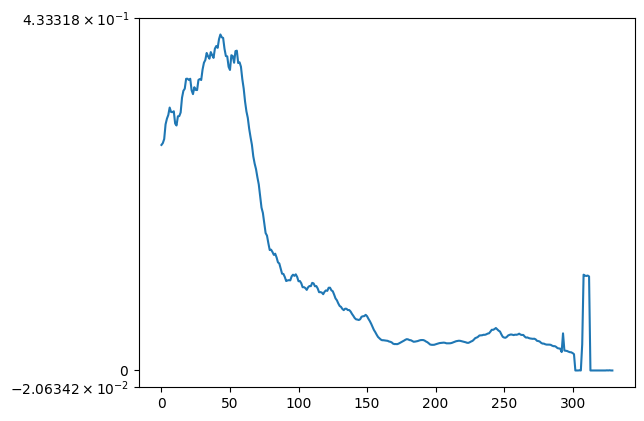

In [ ]:
# Example

#### Problem 1.4 Plot the signal power in the frequency domain before, at, and after the bifurcation point. Draw conclusions. (1 point)

In [ ]:
# TODO

#### P.S. You should obtain something like this

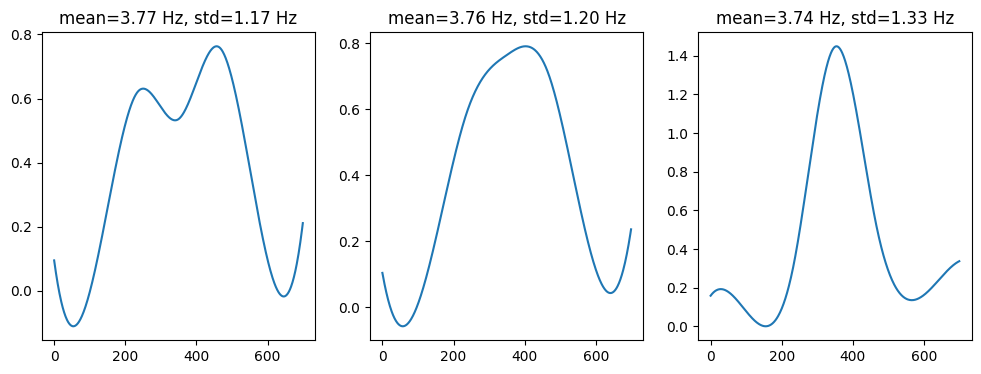

In [ ]:
# Пример работы

## Problem 2: 2D Bratu problem (6 points total)

You have been given a two-dimensional Bratu problem (yes, the one from the seminars):

$$\int_0^1 \int_0^1 \lambda e^u - \frac{1}{2} \left(\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial u}{\partial y}\right)^2\right) dxdy \longrightarrow \underset{u}{extr}$$
$$s.t.$$
$$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$$


1. (2 points) Using the generalised iterative Kantorovich method (it can be used with one term - $u(x,y) = h(x)g(y)$), solve the problem for $\lambda = 1$.
2. (4 points) Conduct bifurcation analysis for the Bratu problem. So, you need to construct two plots:
   1. $\lambda$ vs. determinant of the Jacobian matrix
   2. $\lambda$ vs. $\|u\|_\infty$

**P.S.**

You should have one critical point around $\lambda \approx 7.0$

**P.P.S.**

To simplify your task, instead of $e^u$, you can substitute its expansion in the Taylor series up to the third term: $e^u\approx 1 + u +\frac{u^2}{2!} + \frac{u^3}{3!}$. But then the critical point can shift. We will not reduce points for such a substitution!